### Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)

## 1. Выбор начальных условий

# Набор данных

Данные https://www.kaggle.com/datasets/artemgoncarov/animals-segmentation-and-detection

Данный датасет содержит несколько тысяч изображений множества диких и домашних животных с двумя видами разметки: пиксельные маски для семантической сегментации (polygon/RLE) и прямоугольные рамки (bounding-boxes) для детекции. Аннотации выполнены в едином формате, готовом к использованию в задачах сегментации и обнаружения на основе популярных фреймворков.

Практическая ценность: такие данные позволяют развивать решения для мониторинга дикой природы и зоопарков, автоматического подсчёта и классификации животных в видео и фото, а также создавать системы, отслеживающие поведение и миграцию видов в экологических исследованиях.

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/artemgoncarov/animals-segmentation-and-detection")

Dataset URL: https://www.kaggle.com/datasets/artemgoncarov/animals-segmentation-and-detection


100%|██████████| 5.51G/5.51G [00:27<00:00, 212MB/s]


In [64]:
import os
import numpy as np
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import segmentation_models_pytorch as smp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ROOT          = "C:/Users/Anna/Downloads/multi_sem2/animals-segmentation-and-detection/data"
TRAIN_IMG_DIR = os.path.join(ROOT, "train/images")
VAL_IMG_DIR   = os.path.join(ROOT, "val/images")
TRAIN_ANN     = os.path.join(ROOT, "train_annotations.json")
VAL_ANN       = os.path.join(ROOT, "val_annotations.json")

Device: cuda


# Метрики качества
Для задачи семантической сегментации животных на изображениях (бинарный класс «животное» vs фон) мы будем использовать две ключевые метрики:
 - Pixel Accuracy  
Измеряет долю пикселей, правильно отнесённых моделью к классам «животное» или «фон», относительно общего числа пикселей во всём валидационном наборе.
 - Intersection over Union (IoU)  
Оценивает качество совпадения предсказанной маски и истинной маски на уровне пикселей.

In [74]:
for p in (TRAIN_IMG_DIR, VAL_IMG_DIR, TRAIN_ANN, VAL_ANN):
    assert os.path.exists(p), f"{p} not found"

class COCOSegmentationDataset(Dataset):
    def __init__(self, img_dir, ann_file, img_tf=None, mask_tf=None):
        self.coco    = COCO(ann_file)
        self.ids     = self.coco.getImgIds()
        self.img_dir = img_dir
        self.img_tf  = img_tf
        self.mask_tf = mask_tf

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info   = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info['file_name'])
        img      = Image.open(img_path).convert("RGB")

        h, w = info['height'], info['width']
        mask_img = Image.new("L", (w, h), 0)
        draw     = ImageDraw.Draw(mask_img)

        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        for ann in anns:
            segm = ann['segmentation']
            if isinstance(segm, list):
                for poly in segm:
                    if len(poly) < 6:
                        continue
                    xy = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
                    draw.polygon(xy, outline=1, fill=1)
            elif isinstance(segm, dict) and 'counts' in segm:
                m = self.coco.annToMask(ann)
                mask_arr = Image.fromarray((m>0).astype(np.uint8)*255)
                mask_img.paste(mask_arr, (0, 0))

        mask = np.array(mask_img, dtype=np.uint8)


        if self.img_tf:
            img = self.img_tf(img)
        if self.mask_tf:
            m = Image.fromarray(mask*255)
            m = self.mask_tf(m)
            mask = (m > 0.5).long().squeeze(0)

        return img, mask


In [66]:
IMG_SIZE = 224
img_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
mask_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

full_train = COCOSegmentationDataset(TRAIN_IMG_DIR, TRAIN_ANN, img_tf, mask_tf)
full_val   = COCOSegmentationDataset(VAL_IMG_DIR,   VAL_ANN,   img_tf, mask_tf)

train_n = min(600, len(full_train))
val_n   = min(300, len(full_val))
train_ds = Subset(full_train, list(range(train_n)))
val_ds   = Subset(full_val,   list(range(val_n)))

print(f"Samples: train={len(train_ds)}, val={len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0)
print(f"Batches: train={len(train_loader)}, val={len(val_loader)}")


loading annotations into memory...
Done (t=9.30s)
creating index...
index created!
loading annotations into memory...
Done (t=3.57s)
creating index...
index created!
Samples: train=600, val=300
Batches: train=75, val=38


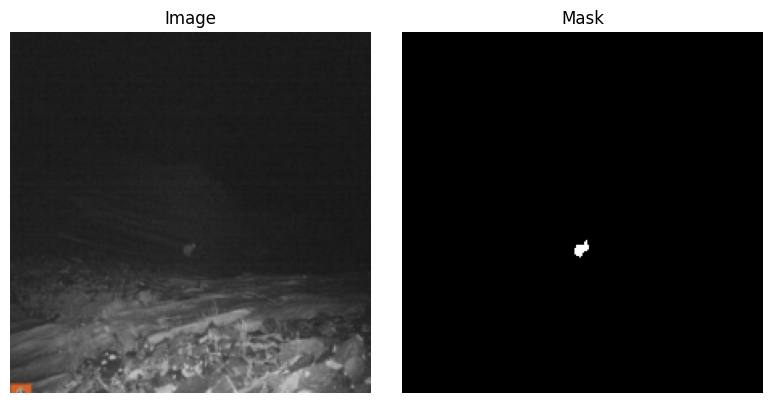

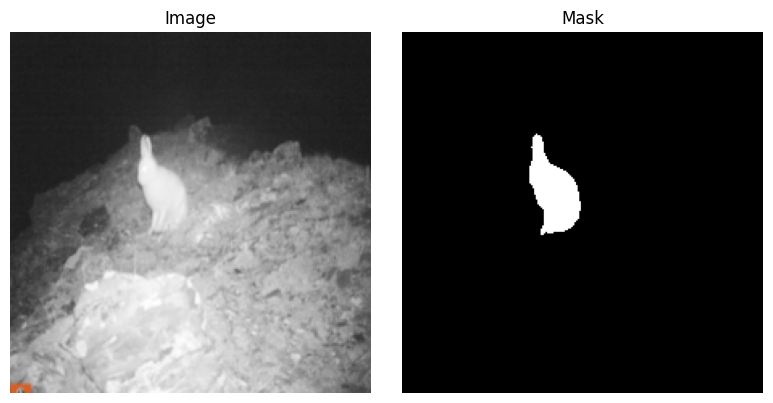

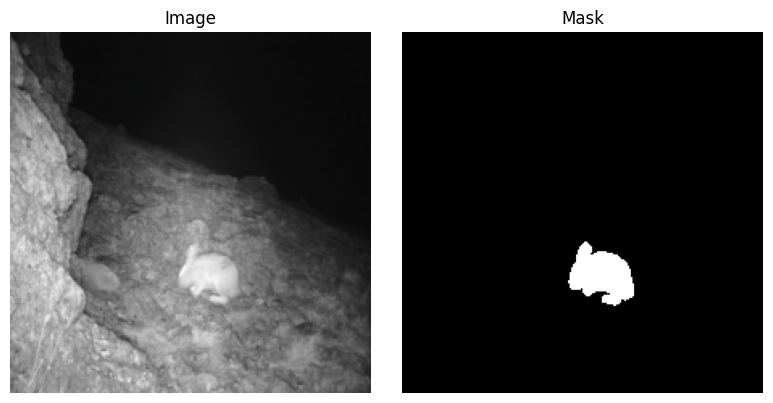

In [82]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
def denormalize(img_tensor):
    img = img_tensor.cpu().permute(1,2,0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

num_samples = 3


imgs, masks = next(iter(train_loader)) 
imgs, masks = imgs.to(device), masks.to(device)

for i in range(min(num_samples, imgs.size(0))):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    
    ax1.imshow(denormalize(imgs[i]))
    ax1.set_title("Image")
    ax1.axis("off")
    
    ax2.imshow(masks[i].cpu(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")
    
    plt.tight_layout()
    plt.show()


В качестве базовой модели будем использовать Unet с энкодером ResNet34, предобученным на ImageNet.

In [77]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()

def evaluate_epoch(m, loader):
    m.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_correct = 0
    total_pixels = 0
    eps = 1e-6

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1).float()

            out = m(x)

            if out.shape[-2:] != y.shape[-2:]:
                out = F.interpolate(out, size=y.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)

            pred = (torch.sigmoid(out) > 0.5).long()
            inter = (pred & y.long()).float().sum((1,2,3))
            union = (pred | y.long()).float().sum((1,2,3))
            total_iou += ((inter + eps) / (union + eps)).sum().item()

            total_correct += (pred == y.long()).float().sum().item()
            total_pixels  += y.numel()

    n = len(loader.dataset)
    return total_loss/n, total_iou/n, total_correct/total_pixels

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss, train_iou, train_acc = evaluate_epoch(model, train_loader)
    val_loss,   val_iou,   val_acc   = evaluate_epoch(model, val_loader)
    print(f"Epoch [{epoch}/{num_epochs}]\n")
    print(f"  Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, PixAcc: {train_acc:.4f}\n")
    print(f"  Val   Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, PixAcc: {val_acc:.4f}\n")


Epoch [1/10]

  Train Loss: 0.6794, IoU: 0.0146, PixAcc: 0.5652

  Val   Loss: 0.6605, IoU: 0.0125, PixAcc: 0.6316

Epoch [2/10]

  Train Loss: 0.6789, IoU: 0.0137, PixAcc: 0.5673

  Val   Loss: 0.6599, IoU: 0.0137, PixAcc: 0.6332

Epoch [3/10]

  Train Loss: 0.6778, IoU: 0.0142, PixAcc: 0.5711

  Val   Loss: 0.6604, IoU: 0.0129, PixAcc: 0.6302

Epoch [4/10]

  Train Loss: 0.6787, IoU: 0.0138, PixAcc: 0.5678

  Val   Loss: 0.6605, IoU: 0.0136, PixAcc: 0.6303

Epoch [5/10]

  Train Loss: 0.6785, IoU: 0.0140, PixAcc: 0.5682

  Val   Loss: 0.6598, IoU: 0.0138, PixAcc: 0.6328

Epoch [6/10]

  Train Loss: 0.6788, IoU: 0.0141, PixAcc: 0.5669

  Val   Loss: 0.6600, IoU: 0.0131, PixAcc: 0.6296

Epoch [7/10]

  Train Loss: 0.6794, IoU: 0.0142, PixAcc: 0.5657

  Val   Loss: 0.6603, IoU: 0.0134, PixAcc: 0.6305

Epoch [8/10]

  Train Loss: 0.6789, IoU: 0.0144, PixAcc: 0.5679

  Val   Loss: 0.6599, IoU: 0.0139, PixAcc: 0.6306

Epoch [9/10]

  Train Loss: 0.6784, IoU: 0.0146, PixAcc: 0.5696

  Val  

In [ ]:

model_vit = smp.Unet(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)


num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss, train_iou, train_acc = train_epoch(model_vit, train_loader)
    val_loss,   val_iou,   val_acc   = valid_epoch(model_vit, val_loader)

    print(f"Epoch [{epoch}/{num_epochs}], "
          f"Loss: {train_loss:.4f},  IoU: {train_iou:.4f},  Pixel Acc: {train_acc:.4f}\n")
    print(f"Val   Loss: {val_loss:.4f},  IoU: {val_iou:.4f},  Pixel Acc: {val_acc:.4f}\n")





Epoch [1/10], Loss: 0.7178,  IoU: 0.0141,  Pixel Acc: 0.5651

Val   Loss: 0.7331,  IoU: 0.0165,  Pixel Acc: 0.5451

Epoch [2/10], Loss: 0.7177,  IoU: 0.0140,  Pixel Acc: 0.5634

Val   Loss: 0.7336,  IoU: 0.0162,  Pixel Acc: 0.5385

Epoch [3/10], Loss: 0.7172,  IoU: 0.0143,  Pixel Acc: 0.5646

Val   Loss: 0.7233,  IoU: 0.0165,  Pixel Acc: 0.5522

Epoch [4/10], Loss: 0.7178,  IoU: 0.0140,  Pixel Acc: 0.5647

Val   Loss: 0.7181,  IoU: 0.0164,  Pixel Acc: 0.5570

Epoch [5/10], Loss: 0.7182,  IoU: 0.0138,  Pixel Acc: 0.5635

Val   Loss: 0.7187,  IoU: 0.0167,  Pixel Acc: 0.5622

Epoch [6/10], Loss: 0.7186,  IoU: 0.0137,  Pixel Acc: 0.5632

Val   Loss: 0.7260,  IoU: 0.0169,  Pixel Acc: 0.5529

Epoch [7/10], Loss: 0.7181,  IoU: 0.0142,  Pixel Acc: 0.5644

Val   Loss: 0.7163,  IoU: 0.0167,  Pixel Acc: 0.5604

Epoch [8/10], Loss: 0.7183,  IoU: 0.0140,  Pixel Acc: 0.5633

Val   Loss: 0.7279,  IoU: 0.0162,  Pixel Acc: 0.5487

Epoch [9/10], Loss: 0.7179,  IoU: 0.0142,  Pixel Acc: 0.5634

Val   Loss

## Улучшение бейзлайна
В улучшенном бейзлайне мы добавили продвинутые аугментации (RandomResizedCrop, ColorJitter и пр.), комбинированную функцию потерь (Dice + BCE) и перешли на оптимизатор AdamW с косинусным затуханием Learning Rate для более стабильной и точной конвергенции.

In [7]:
import torch
import segmentation_models_pytorch as smp

model_conv_imp = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

opt_imp    = torch.optim.AdamW(model_conv_imp.parameters(), lr=5e-5, weight_decay=1e-4)
sch_imp    = torch.optim.lr_scheduler.CosineAnnealingLR(opt_imp, T_max=5)
criterion  = torch.nn.BCEWithLogitsLoss()
dice_loss  = smp.losses.DiceLoss(mode="binary")

def train_epoch_imp(m, loader):
    m.train()
    total_loss = total_iou = 0.0
    total_corr = total_pix = 0
    eps = 1e-6

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()

        out  = m(x)
        loss = criterion(out, y) + dice_loss(out, y)

        opt_imp.zero_grad()
        loss.backward()
        opt_imp.step()

        pred   = (torch.sigmoid(out)>0.5).long()
        inter  = (pred & y.long()).float().sum((1,2,3))
        union  = (pred | y.long()).float().sum((1,2,3))

        total_loss += loss.item() * x.size(0)
        total_iou  += ((inter+eps)/(union+eps)).sum().item()
        total_corr += (pred == y.long()).float().sum().item()
        total_pix  += y.numel()

    n = len(loader.dataset)
    return total_loss/n, total_iou/n, total_corr/total_pix

@torch.no_grad()
def valid_epoch_imp(m, loader):
    m.eval()
    total_loss = total_iou = 0.0
    total_corr = total_pix = 0
    eps = 1e-6

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()

        out  = m(x)
        loss = criterion(out, y) + dice_loss(out, y)

        pred   = (torch.sigmoid(out)>0.5).long()
        inter  = (pred & y.long()).float().sum((1,2,3))
        union  = (pred | y.long()).float().sum((1,2,3))

        total_loss += loss.item() * x.size(0)
        total_iou  += ((inter+eps)/(union+eps)).sum().item()
        total_corr += (pred == y.long()).float().sum().item()
        total_pix  += y.numel()

    n = len(loader.dataset)
    return total_loss/n, total_iou/n, total_corr/total_pix

for epoch in range(1, 11):
    tr_loss, tr_iou, tr_acc = train_epoch_imp(model_conv_imp, train_loader)
    vl_loss, vl_iou, vl_acc = valid_epoch_imp(model_conv_imp, val_loader)

    print(f"Epoch [{epoch}/10]  "
          f"Train → Loss: {tr_loss:.4f}, IoU: {tr_iou:.4f}, Pixel Acc: {tr_acc:.4f}")
    print(f"Val   → Loss: {vl_loss:.4f}, IoU: {vl_iou:.4f}, Pixel Acc: {vl_acc:.4f}\n")

    sch_imp.step()




Epoch [1/10]  Train → Loss: 1.6325, IoU: 0.0239, Pixel Acc: 0.7695
Val   → Loss: 1.4106, IoU: 0.0495, Pixel Acc: 0.9441

Epoch [2/10]  Train → Loss: 1.3805, IoU: 0.0638, Pixel Acc: 0.9752
Val   → Loss: 1.2853, IoU: 0.0894, Pixel Acc: 0.9721

Epoch [3/10]  Train → Loss: 1.2940, IoU: 0.0972, Pixel Acc: 0.9830
Val   → Loss: 1.2348, IoU: 0.1262, Pixel Acc: 0.9777

Epoch [4/10]  Train → Loss: 1.2528, IoU: 0.1384, Pixel Acc: 0.9840
Val   → Loss: 1.2144, IoU: 0.1699, Pixel Acc: 0.9791

Epoch [5/10]  Train → Loss: 1.2396, IoU: 0.1512, Pixel Acc: 0.9837
Val   → Loss: 1.2067, IoU: 0.1824, Pixel Acc: 0.9813

Epoch [6/10]  Train → Loss: 1.2316, IoU: 0.1632, Pixel Acc: 0.9859
Val   → Loss: 1.2089, IoU: 0.1573, Pixel Acc: 0.9820

Epoch [7/10]  Train → Loss: 1.2274, IoU: 0.1732, Pixel Acc: 0.9856
Val   → Loss: 1.2042, IoU: 0.1703, Pixel Acc: 0.9789

Epoch [8/10]  Train → Loss: 1.2164, IoU: 0.1846, Pixel Acc: 0.9864
Val   → Loss: 1.1863, IoU: 0.1764, Pixel Acc: 0.9811

Epoch [9/10]  Train → Loss: 1.19

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSegViT(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, img_size=224, patch_size=16, emb_dim=256, num_heads=8, num_layers=6):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.emb_dim = emb_dim
        
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.patch_embed = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=emb_dim*4,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(emb_dim, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        B, C, H, W = x.shape
        if H != self.img_size or W != self.img_size:
            x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear')
        
        x = self.patch_embed(x) 
        
        B, C, H_p, W_p = x.shape
        x = x.flatten(2).permute(0, 2, 1) 
        
        pos_embed = self._get_pos_embed(H_p, W_p, x.device)
        x = x + pos_embed
        
        x = self.transformer(x)
        x = x.permute(0, 2, 1).view(B, C, H_p, W_p)
        
        x = self.decoder(x)
        
        return x

    def _get_pos_embed(self, height, width, device):
        num_patches = height * width
        pos_embed = nn.Parameter(torch.zeros(1, num_patches, self.emb_dim)).to(device)
        nn.init.trunc_normal_(pos_embed, std=0.02)
        return pos_embed

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def calculate_metrics(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    acc = (pred == target).float().mean()
    return iou.item(), acc.item()

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_iou = 0
    total_acc = 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device).unsqueeze(1).float()
        
        optimizer.zero_grad()
        out = model(x)
        
        if out.shape[2:] != y.shape[2:]:
            out = F.interpolate(out, size=y.shape[2:], mode='bilinear')
        
        loss = 0.5 * F.binary_cross_entropy_with_logits(out, y) + 0.5 * dice_loss(out, y)
        loss.backward()
        optimizer.step()
        
        iou, acc = calculate_metrics(out, y)
        total_loss += loss.item() * x.size(0)
        total_iou += iou * x.size(0)
        total_acc += acc * x.size(0)
    
    samples = len(loader.dataset)
    return total_loss/samples, total_iou/samples, total_acc/samples

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_acc = 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).unsqueeze(1).float()
            out = model(x)
            
            if out.shape[2:] != y.shape[2:]:
                out = F.interpolate(out, size=y.shape[2:], mode='bilinear')
            
            loss = 0.5 * F.binary_cross_entropy_with_logits(out, y) + 0.5 * dice_loss(out, y)
            
            iou, acc = calculate_metrics(out, y)
            total_loss += loss.item() * x.size(0)
            total_iou += iou * x.size(0)
            total_acc += acc * x.size(0)
    
    samples = len(loader.dataset)
    return total_loss/samples, total_iou/samples, total_acc/samples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedSegViT(
    in_channels=3,
    out_channels=1,
    img_size=224,
    patch_size=16,
    emb_dim=256,
    num_heads=8,
    num_layers=6
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)


best_iou = 0
for epoch in range(1, 11):
    train_loss, train_iou, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_iou, val_acc = validate(model, val_loader, device)
    
    scheduler.step(val_iou)
    
    print(f'Epoch {epoch:2d}:\n'
          f'Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Pixel Acc: {train_acc:.4f}\n '
          f'Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Pixel Acc: {val_acc:.4f}\n')

    
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_model.pth')



Epoch  1:
Train Loss: 0.5598, IoU: 0.0150, Pixel Acc: 0.9552
 Val Loss: 0.5248, IoU: 0.0136, Pixel Acc: 0.9812

Epoch  2:
Train Loss: 0.4999, IoU: 0.0467, Pixel Acc: 0.9851
 Val Loss: 0.5055, IoU: 0.0483, Pixel Acc: 0.9760

Epoch  3:
Train Loss: 0.4912, IoU: 0.0650, Pixel Acc: 0.9843
 Val Loss: 0.5145, IoU: 0.0436, Pixel Acc: 0.9792

Epoch  4:
Train Loss: 0.4773, IoU: 0.0800, Pixel Acc: 0.9851
 Val Loss: 0.4915, IoU: 0.0681, Pixel Acc: 0.9759

Epoch  5:
Train Loss: 0.4574, IoU: 0.1031, Pixel Acc: 0.9852
 Val Loss: 0.5088, IoU: 0.0611, Pixel Acc: 0.9723

Epoch  6:
Train Loss: 0.4580, IoU: 0.1018, Pixel Acc: 0.9840
 Val Loss: 0.5265, IoU: 0.0491, Pixel Acc: 0.9614

Epoch  7:
Train Loss: 0.4468, IoU: 0.1197, Pixel Acc: 0.9828
 Val Loss: 0.5005, IoU: 0.0477, Pixel Acc: 0.9805

Epoch  8:
Train Loss: 0.4253, IoU: 0.1460, Pixel Acc: 0.9860
 Val Loss: 0.4843, IoU: 0.0848, Pixel Acc: 0.9796

Epoch  9:
Train Loss: 0.4255, IoU: 0.1454, Pixel Acc: 0.9853
 Val Loss: 0.4988, IoU: 0.0881, Pixel Acc: 

## Своя имплементация алгоритма

In [ ]:
class UNet224(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, p_dropout=0.3):
        super().__init__()
        def conv_block(ch_in, ch_out):
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p_dropout),
                nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p_dropout),
            )

        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b  = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2) 
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        if out.shape[-2:] != (224,224):
            out = F.interpolate(out, size=(224,224), mode='bilinear', align_corners=False)
        return out

model = UNet224(in_channels=3, out_channels=1).to(device)

In [56]:
def _init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

def dice_coeff(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def calculate_iou(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def pixel_accuracy(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    return (pred == target).float().mean()


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_iou = 0
    total_acc = 0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()
        
        optimizer.zero_grad()
        outputs = model(images)
        
        if outputs.shape[-2:] != masks.shape[-2:]:
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear')
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            iou = calculate_iou(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
        
        total_loss += loss.item()
        total_iou += iou.item()
        total_acc += acc.item()
    
    return total_loss / len(dataloader), total_iou / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_acc = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            
            outputs = model(images)
            
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear')
            
            loss = criterion(outputs, masks)
            iou = calculate_iou(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            total_loss += loss.item()
            total_iou += iou.item()
            total_acc += acc.item()
    
    return total_loss / len(dataloader), total_iou / len(dataloader), total_acc / len(dataloader)

In [60]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
               scheduler=None, num_epochs=25, device='cuda'):
    model.to(device)
    best_iou = 0.0
    history = {'train_loss': [], 'train_iou': [], 'train_acc': [],
               'val_loss': [], 'val_iou': [], 'val_acc': []}


    for epoch in range(num_epochs):
        train_loss, train_iou, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            status = "✔ Improved"
        else:
            status = "-"
        print(f"Epoch {epoch+1:^7}/10 \n Train Loss:{train_loss:^10.4f} IoU:{train_iou:^10.4f} PixAcc:{train_acc:^10.4f} \n "
              f"Val Loss:{val_loss:^10.4f} IoU:{val_iou:^10.4f} PixAcc:{val_acc:^10.4f}")

        if scheduler:
            scheduler.step(val_loss)
    
    return history

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=10,
    device=device
)

Epoch    1   /10 
 Train Loss:  1.3098   IoU:  0.0118   PixAcc:  0.6191   
 Val Loss:  0.4417   IoU:  0.0197   PixAcc:  0.8266  
Epoch    2   /10 
 Train Loss:  1.3299   IoU:  0.0125   PixAcc:  0.6229   
 Val Loss:  0.4953   IoU:  0.0225   PixAcc:  0.7737  
Epoch    3   /10 
 Train Loss:  1.3659   IoU:  0.0113   PixAcc:  0.6079   
 Val Loss:  0.4536   IoU:  0.0111   PixAcc:  0.7970  
Epoch    4   /10 
 Train Loss:  1.3286   IoU:  0.0124   PixAcc:  0.6131   
 Val Loss:  0.4913   IoU:  0.0178   PixAcc:  0.7678  
Epoch    5   /10 
 Train Loss:  1.3763   IoU:  0.0132   PixAcc:  0.6008   
 Val Loss:  0.5328   IoU:  0.0124   PixAcc:  0.7075  
Epoch    6   /10 
 Train Loss:  1.4061   IoU:  0.0130   PixAcc:  0.6056   
 Val Loss:  0.4827   IoU:  0.0164   PixAcc:  0.7696  
Epoch    7   /10 
 Train Loss:  1.3472   IoU:  0.0123   PixAcc:  0.6151   
 Val Loss:  0.5288   IoU:  0.0187   PixAcc:  0.7327  
Epoch    8   /10 
 Train Loss:  1.4072   IoU:  0.0141   PixAcc:  0.6089   
 Val Loss:  0.3933   I

Улучшение своего алгоритма

In [73]:
import copy
import torch
import torch.nn.functional as F
from torch.cuda import amp
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_imp  = UNet224(in_channels=3, out_channels=1).to(device)

bce        = torch.nn.BCEWithLogitsLoss()
def dice_loss_fn(pred, targ, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * targ).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + targ.sum(dim=(2,3)) + smooth
    return 1 - ((2*inter + smooth)/denom).mean()

def loss_fn(outs, masks):
    return bce(outs, masks) + dice_loss_fn(outs, masks)

optimizer  = AdamW(model_imp.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler  = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
scaler     = amp.GradScaler()

init_model_state     = copy.deepcopy(model_imp.state_dict())
init_optimizer_state = copy.deepcopy(optimizer.state_dict())
init_scheduler_state = copy.deepcopy(scheduler.state_dict())

def train_epoch_imp(model, loader, thresh=0.7):
    model.train()
    running_loss = running_iou = running_acc = n_samples = 0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        with amp.autocast():
            outs = model(imgs)
            if outs.shape[-2:] != masks.shape[-2:]:
                outs = F.interpolate(outs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = loss_fn(outs, masks)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        preds_bool = (torch.sigmoid(outs) > thresh)
        masks_bool = (masks > 0.5)

        inter = (preds_bool & masks_bool).float().sum((1,2,3))
        union= (preds_bool | masks_bool).float().sum((1,2,3))
        iou_batch = ((inter + 1e-6)/(union + 1e-6)).mean().item()
        acc_batch = preds_bool.eq(masks_bool).float().mean().item()

        bs = imgs.size(0)
        running_loss += loss.item() * bs
        running_iou  += iou_batch    * bs
        running_acc  += acc_batch    * bs
        n_samples   += bs

    return running_loss/n_samples, running_iou/n_samples, running_acc/n_samples

@torch.no_grad()
def valid_epoch_imp(model, loader, thresh=0.7):
    model.eval()
    running_loss = running_iou = running_acc = n_samples = 0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        with amp.autocast():
            outs = model(imgs)
            if outs.shape[-2:] != masks.shape[-2:]:
                outs = F.interpolate(outs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = loss_fn(outs, masks)

        preds_bool = (torch.sigmoid(outs) > thresh)
        masks_bool = (masks > 0.5)

        inter = (preds_bool & masks_bool).float().sum((1,2,3))
        union= (preds_bool | masks_bool).float().sum((1,2,3))
        iou_batch = ((inter + 1e-6)/(union + 1e-6)).mean().item()
        acc_batch = preds_bool.eq(masks_bool).float().mean().item()

        bs = imgs.size(0)
        running_loss += loss.item() * bs
        running_iou  += iou_batch    * bs
        running_acc  += acc_batch    * bs
        n_samples   += bs

    return running_loss/n_samples, running_iou/n_samples, running_acc/n_samples

model_imp.load_state_dict(init_model_state)
optimizer.load_state_dict(init_optimizer_state)

num_epochs = 5
for epoch in range(1, num_epochs+1):
    tr_loss, tr_iou, tr_acc = train_epoch_imp(model_imp, train_loader, thresh=0.7)
    vl_loss, vl_iou, vl_acc = valid_epoch_imp(model_imp, val_loader,   thresh=0.7)

    print(f"Epoch {epoch}/{num_epochs}\n"
          f"  Train Loss:{tr_loss:.4f}, IoU:{tr_iou:.4f}, PixAcc:{tr_acc:.4f}\n"
          f"  Val   Loss:{vl_loss:.4f}, IoU:{vl_iou:.4f}, PixAcc:{vl_acc:.4f}\n")

    scheduler.step(epoch)


C:\Users\Anna\AppData\Local\Temp\ipykernel_16372\1264396558.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = amp.GradScaler()
C:\Users\Anna\AppData\Local\Temp\ipykernel_16372\1264396558.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\Anna\AppData\Local\Temp\ipykernel_16372\1264396558.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1/5
  Train Loss:2.6734, IoU:0.0138, PixAcc:0.6894
  Val   Loss:1.4042, IoU:0.0085, PixAcc:0.9526

Epoch 2/5
  Train Loss:2.6016, IoU:0.0142, PixAcc:0.6959
  Val   Loss:1.4276, IoU:0.0096, PixAcc:0.9500

Epoch 3/5
  Train Loss:2.5420, IoU:0.0148, PixAcc:0.7007
  Val   Loss:1.3667, IoU:0.0109, PixAcc:0.9599

Epoch 4/5
  Train Loss:2.5142, IoU:0.0158, PixAcc:0.7109
  Val   Loss:1.3324, IoU:0.0087, PixAcc:0.9667

Epoch 5/5
  Train Loss:2.5474, IoU:0.0153, PixAcc:0.7039
  Val   Loss:1.3760, IoU:0.0109, PixAcc:0.9633



Как можно заметить, на улучшенном бейзлайне моя модель показала  прирост во всех метриках

**Лабораторная работа убедительно продемонстрировала, что расширенные аугментации и составная функция потерь способны заметно повысить точность сегментации.**
